# 1. Do all necessary imports

In [2]:
import os
import cv2
import joblib
import pickle
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
from collections import Counter, defaultdict
from tqdm import tqdm
from joblib import parallel_backend
from skimage import color
from skimage.feature import hog
from skimage.filters import gabor
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, log_loss
from sklearn.model_selection import GridSearchCV, train_test_split

# 2. Install and Import pywt

In [3]:
try:
    import pywt
except ImportError:
    !pip install PyWavelets
    import pywt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 22.0 MB/s eta 0:00:00


# 3. Install and Import mediapipe

In [4]:
try:
    import mediapipe as mp
except ImportError:
    !pip install mediapipe
    import mediapipe as mp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 21.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.6 which is incompatible.


# 4. Install and Import tqdm_joblib

In [5]:
try:
    from tqdm_joblib import tqdm_joblib
except ImportError:
    !pip install tqdm_joblib
    from tqdm_joblib import tqdm_joblib

/usr/local/lib/python3.11/dist-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# 5. Import google drive

In [6]:
from google.colab.patches import cv2_imshow # Import cv2_imshow from google.colab.patches
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 6. Setup Google Drive

In [7]:
# Set up project directories
project_path = "/content/drive/MyDrive/281/project/FacialRecognition"
image_dir = os.path.join(project_path, "Image/aligned")
denoised_image_dir = os.path.join(project_path, "Image/denoised")
os.makedirs(denoised_image_dir, exist_ok=True)

# 7. Basic EDA helper functions

In [8]:
# Load Image and Label
def load_image_label_pairs(image_dir, label_file):
    label_dict = {}
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                label_dict[parts[0]] = parts[1]
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
    return image_files, label_dict

# Load labels
def load_labels(label_file):
    label_dict = {}
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                label_dict[parts[0]] = parts[1]
    return label_dict

# Display class distribution
def display_class_distribution(label_dict):
    dist = Counter(label_dict.values())
    print("Class Distribution:")
    emotion_names = []
    counts = []
    for cls, count in sorted(dist.items(), key=lambda x: int(x[0])):
        emotion = emotion_map.get(cls, f"Unknown({cls})")
        emotion_names.append(emotion)
        counts.append(count)
        print(f"Class {cls} ({emotion}): {count}")

    # Plot histogram
    plt.figure(figsize=(8, 5))
    plt.bar(emotion_names, counts, color='skyblue')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 8. Pre-Processing Helpers

In [9]:
# Apply horizontal flip for imbalance (augmentation)
def augment_by_flip(image, label):
    flipped = cv2.flip(image, 1)
    return flipped, label

# Noise reduction and save to separate folder
def apply_noise_reduction(image):
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

# Process and Save de-noised images
def process_and_save_denoised_images(image_dir, output_dir, label_dict):
    os.makedirs(output_dir, exist_ok=True)
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
    for fname in tqdm(image_files, desc="Denoising images", unit="img"):
        output_path = os.path.join(output_dir, fname)
        if os.path.exists(output_path):
            continue  # Skip already processed image
        path = os.path.join(image_dir, fname)
        img = cv2.imread(path)
        denoised = apply_noise_reduction(img)
        cv2.imwrite(os.path.join(output_dir, fname), denoised)

# Augment underrepresented classes (horizontal flip)
def augment_minority_classes(image_dir, output_dir, label_dict, threshold=0):
    os.makedirs(output_dir, exist_ok=True)
    label_counts = Counter(label_dict.values())
    minority_classes = [cls for cls, count in label_counts.items() if count <= threshold] if threshold > 0 else []
    if not minority_classes:
        mean_count = np.mean(list(label_counts.values()))
        minority_classes = [cls for cls, count in label_counts.items() if count < mean_count]

    print(f"Minority classes selected for augmentation: {minority_classes}")
    updated_labels = {}

    for fname in tqdm(os.listdir(image_dir), desc="Augmenting minority classes", unit="img"):
        if not fname.endswith(('_aligned.jpg', '_aligned.png')):
            continue

        image_id = fname.replace('_aligned.jpg', '.jpg').replace('_aligned.png', '.png')
        label = label_dict.get(image_id)

        if label in minority_classes:
            path = os.path.join(image_dir, fname)
            flipped_fname = fname.replace('.', '_flipped.')
            flipped_path = os.path.join(output_dir, flipped_fname)
            if os.path.exists(flipped_path):
                continue  # Skip already processed image

            img = cv2.imread(path)
            flipped, _ = augment_by_flip(img, label)
            cv2.imwrite(flipped_path, flipped)
            updated_labels[flipped_fname] = label

    # Update the original label file with flipped entries
    if updated_labels:
        os.rename(label_file, label_file_bak)
        with open(label_file, "w") as lf:
            for k, v in label_dict.items():
                lf.write(f"{k} {v}\n")
            for k, v in updated_labels.items():
                lf.write(f"{k} {v}\n")

# 9. Display Class distribution

Class Distribution:
Class 1 (Surprise): 1619
Class 2 (Fear): 355
Class 3 (Disgust): 877
Class 4 (Happiness): 5957
Class 5 (Sadness): 2460
Class 6 (Anger): 867
Class 7 (Neutral): 3204


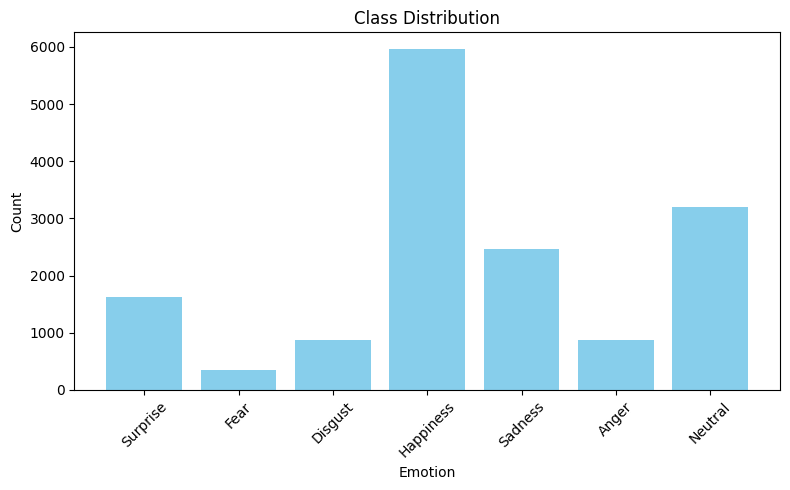

In [10]:
# Directories and label map
# image_dir = os.path.join(project_path, "Image/aligned")
label_file = os.path.join(project_path, "EmoLabel/list_patition_label.txt")
label_file_bak = os.path.join(project_path, "EmoLabel/list_patition_label.txt.bak")

feature_dir = os.path.join(project_path, "Output/Features")
model_dir = os.path.join(project_path, "Output/Models")
os.makedirs(feature_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

emotion_map = {
    "1": "Surprise", "2": "Fear", "3": "Disgust",
    "4": "Happiness", "5": "Sadness", "6": "Anger", "7": "Neutral"
}

# Load images and labels
image_files, label_dict = load_image_label_pairs(image_dir, label_file)
labels = [label_dict[f.split('_aligned')[0]] for f in image_files if f.split('_aligned')[0] in label_dict]

# Display class distribution
if os.path.exists(label_file_bak):
    display_class_distribution(load_labels(label_file_bak))
else:
    display_class_distribution(label_dict)

# 10. Apply Pre-Processing

Minority classes selected for augmentation: ['6', '2', '3']


Denoising images: 100%|██████████| 21517/21517 [00:03<00:00, 6257.02img/s]


Class Distribution:
Class 1 (Surprise): 3238
Class 2 (Fear): 710
Class 3 (Disgust): 1754
Class 4 (Happiness): 5957
Class 5 (Sadness): 4920
Class 6 (Anger): 1734
Class 7 (Neutral): 3204


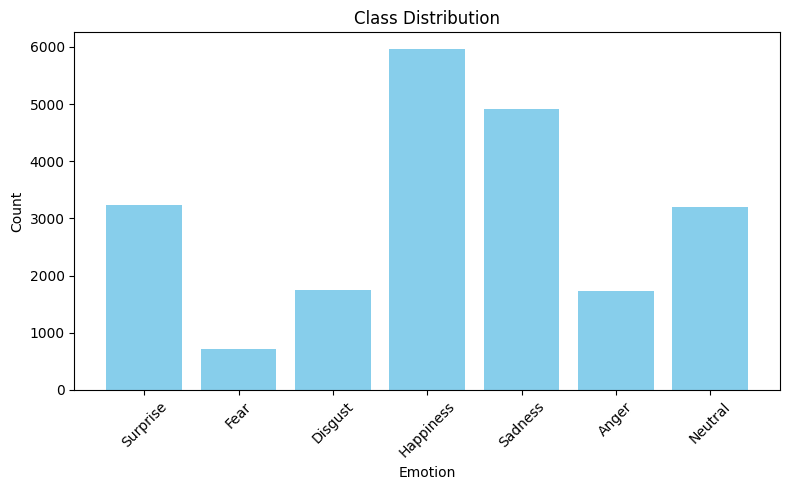

In [11]:
# Augment minority classes
augment_minority_classes(image_dir, image_dir, label_dict, threshold=3000)

# Apply noise reduction and save to denoised folder
process_and_save_denoised_images(image_dir, denoised_image_dir, label_dict)

# Load images and labels
image_files, label_dict = load_image_label_pairs(image_dir, label_file)
labels = [label_dict[f.split('_aligned')[0]] for f in image_files if f.split('_aligned')[0] in label_dict]

# Display class distribution
display_class_distribution(label_dict)

# 11. Define Feature Parameters

In [12]:
# Different configurations for HOG visualization
hog_params = [
    {"pixels_per_cell": (8, 8), "cells_per_block": (2, 2), "orientations": 9, "title": "Standard 8x8 & 9 Ori)"},
    {"pixels_per_cell": (4, 4), "cells_per_block": (2, 2), "orientations": 9, "title": "Smaller 4x4 & 9 Ori"},
    {"pixels_per_cell": (4, 4), "cells_per_block": (2, 2), "orientations": 12, "title": "Smaller 4x4 & 12 Ori"},
    {"pixels_per_cell": (2, 2), "cells_per_block": (2, 2), "orientations": 20, "title": "Smaller 2x2 & 20 Ori"},
]

# Define parameter dictionary for Canny and Sobel edge detection
edge_detection_params = {
    "Canny (50,100)": {"method": "Canny", "params": {"threshold1": 50, "threshold2": 100}},
    "Canny (50,200)": {"method": "Canny", "params": {"threshold1": 50, "threshold2": 200}},
    "Sobel (ksize=3)": {"method": "Sobel", "params": {"ksize": 3}},
    "Sobel (ksize=5)": {"method": "Sobel", "params": {"ksize": 5}},
    "Sobel (ksize=7)": {"method": "Sobel", "params": {"ksize": 7}},
}

# Define parameter dictionary for Gabor filter with different orientations and frequencies
# theta 0, 45, 90, 135
gabor_params = {
    "Gabor (θ=0, f=0.20, σ=2, bw=0.5, off=π)": {"theta": 0, "frequency": 0.2, "sigma": 2, "bandwidth": 0.5, "offset": np.pi},
    "Gabor (θ=45, f=0.20, σ=2, bw=0.5, off=π)": {"theta": 45, "frequency": 0.2, "sigma": 2, "bandwidth": 0.5, "offset": np.pi},
    "Gabor (θ=90, f=0.20, σ=2, bw=0.5, off=π)": {"theta": 90, "frequency": 0.2, "sigma": 2, "bandwidth": 0.5, "offset": np.pi},
    "Gabor (θ=135, f=0.20, σ=2, bw=0.5, off=π)": {"theta": 135, "frequency": 0.2, "sigma": 2, "bandwidth": 0.5, "offset": np.pi},
}

# Compute HOG features
def compute_hog(image, params):
    """Compute HOG features and return visualization."""
    hog_features, hog_image = hog(image, pixels_per_cell=params["pixels_per_cell"],
                                  cells_per_block=params["cells_per_block"],
                                  visualize=True, block_norm='L2-Hys',
                                  orientations=params["orientations"])
    return hog_features, hog_image

# Compute CANNY/SOBEL Features
def compute_edge(image, method, params):
    edge_features = []
    if method == "Canny":
        edge = cv2.Canny(image, params["threshold1"], params["threshold2"])
    elif method == "Sobel":
        sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=params["ksize"])
        sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=params["ksize"])
        # edge = cv2.magnitude(sobelx, sobely)
        edge = np.hypot(sobelx, sobely)
    edge_features.append(edge.flatten())

    return edge_features, edge

# Gabor Features
def compute_gabor(image, params):
    gabor_features = []
    response, gabor_image = gabor(image, frequency=params["frequency"], theta=np.deg2rad(params["theta"]),
                        sigma_x=params["sigma"], sigma_y=params["sigma"],
                        bandwidth=params["bandwidth"], offset=params["offset"])
    gabor_features.append(response.flatten())
    return gabor_features, gabor_image


# 12. Start Experiment with a random Image

In [13]:
# Select a random image file
if not image_files:
    raise ValueError("No image files found in the directory!")

random_image = random.choice(image_files)
image_path = os.path.join(image_dir, random_image)
denoised_image_path = os.path.join(denoised_image_dir, random_image)

print("Selected Image:", image_path)
print("Selected Denoised Image:", denoised_image_path)

image_asis = cv2.imread(image_path)
image_gray_scl = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image_bgr_gray = cv2.cvtColor(image_asis, cv2.COLOR_BGR2GRAY)

denoised_image_asis = cv2.imread(denoised_image_path)
denoised_image_gray_scl = cv2.imread(denoised_image_path, cv2.IMREAD_GRAYSCALE)
denoised_image_bgr_gray = cv2.cvtColor(denoised_image_asis, cv2.COLOR_BGR2GRAY)

# Resize for consistency
image_gray_scl_rsz = cv2.resize(image_gray_scl, (128, 128))
image_asis_rsz = cv2.resize(image_asis, (128, 128))

denoised_image_gray_scl_rsz = cv2.resize(denoised_image_gray_scl, (128, 128))
denoised_image_asis_rsz = cv2.resize(denoised_image_asis, (128, 128))

Selected Image: /content/drive/MyDrive/281/project/FacialRecognition/Image/aligned/train_03891_aligned.jpg
Selected Denoised Image: /content/drive/MyDrive/281/project/FacialRecognition/Image/denoised/train_03891_aligned.jpg


# 13. Experiments with HOG

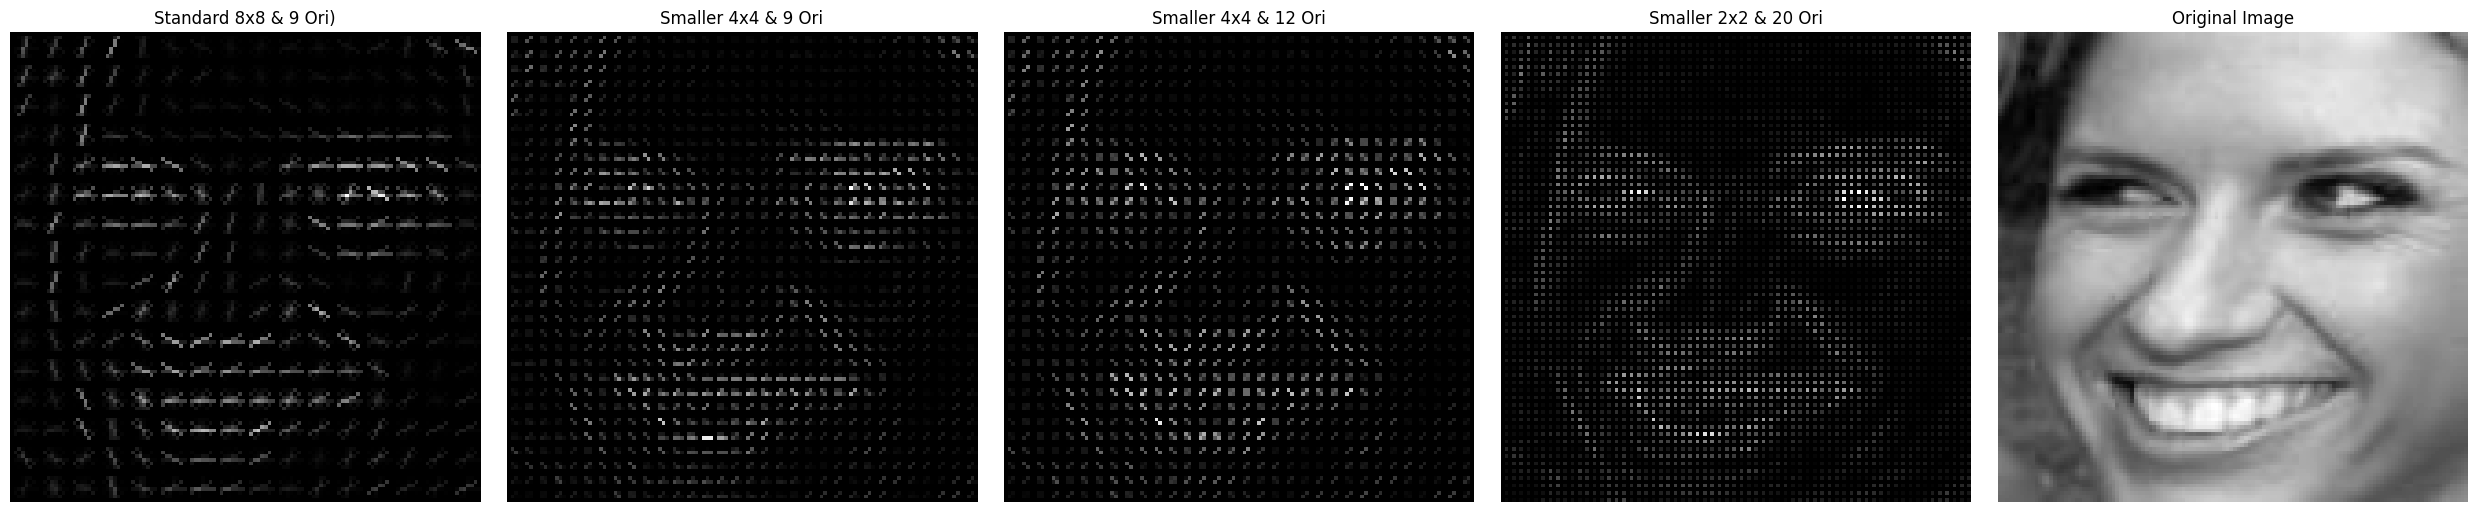

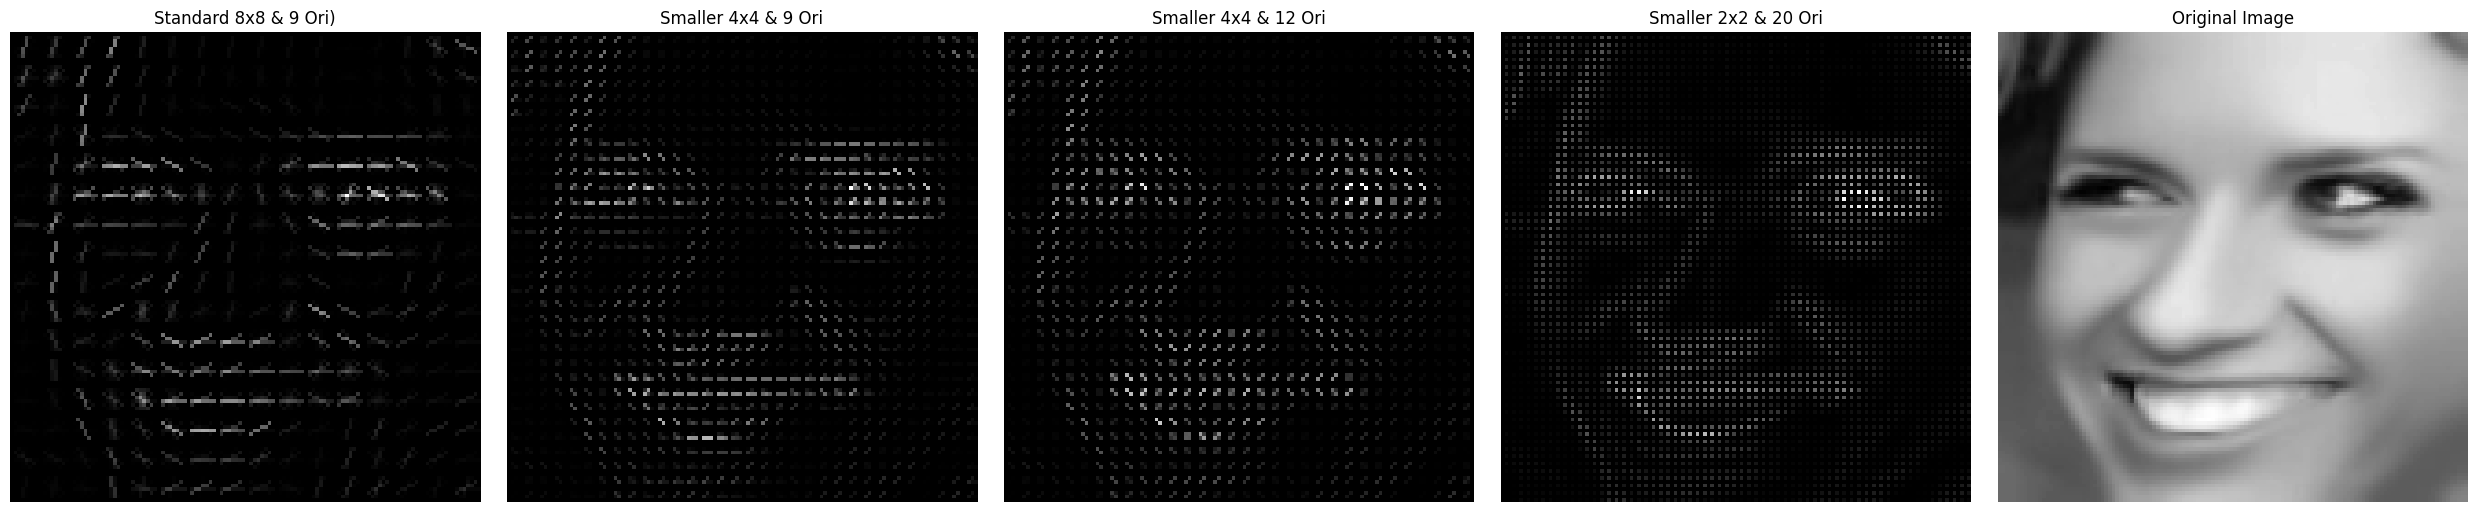

In [14]:
# Generate HOG visualizations for each setting
def apply_hog_visualization(image):
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    axes = axes.flatten()

    for i, params in enumerate(hog_params):
        _, hog_image = compute_hog(image, params)
        axes[i].imshow(hog_image, cmap='gray')
        axes[i].set_title(params["title"])
        axes[i].axis("off")

    # Original Image for Reference
    axes[-1].imshow(image, cmap='gray')
    axes[-1].set_title("Original Image")
    axes[-1].axis("off")

    plt.tight_layout()
    plt.show()

apply_hog_visualization(image_gray_scl_rsz)
apply_hog_visualization(denoised_image_gray_scl_rsz)

# 14. Experiments with EDGE (CANNY and SOBEL)

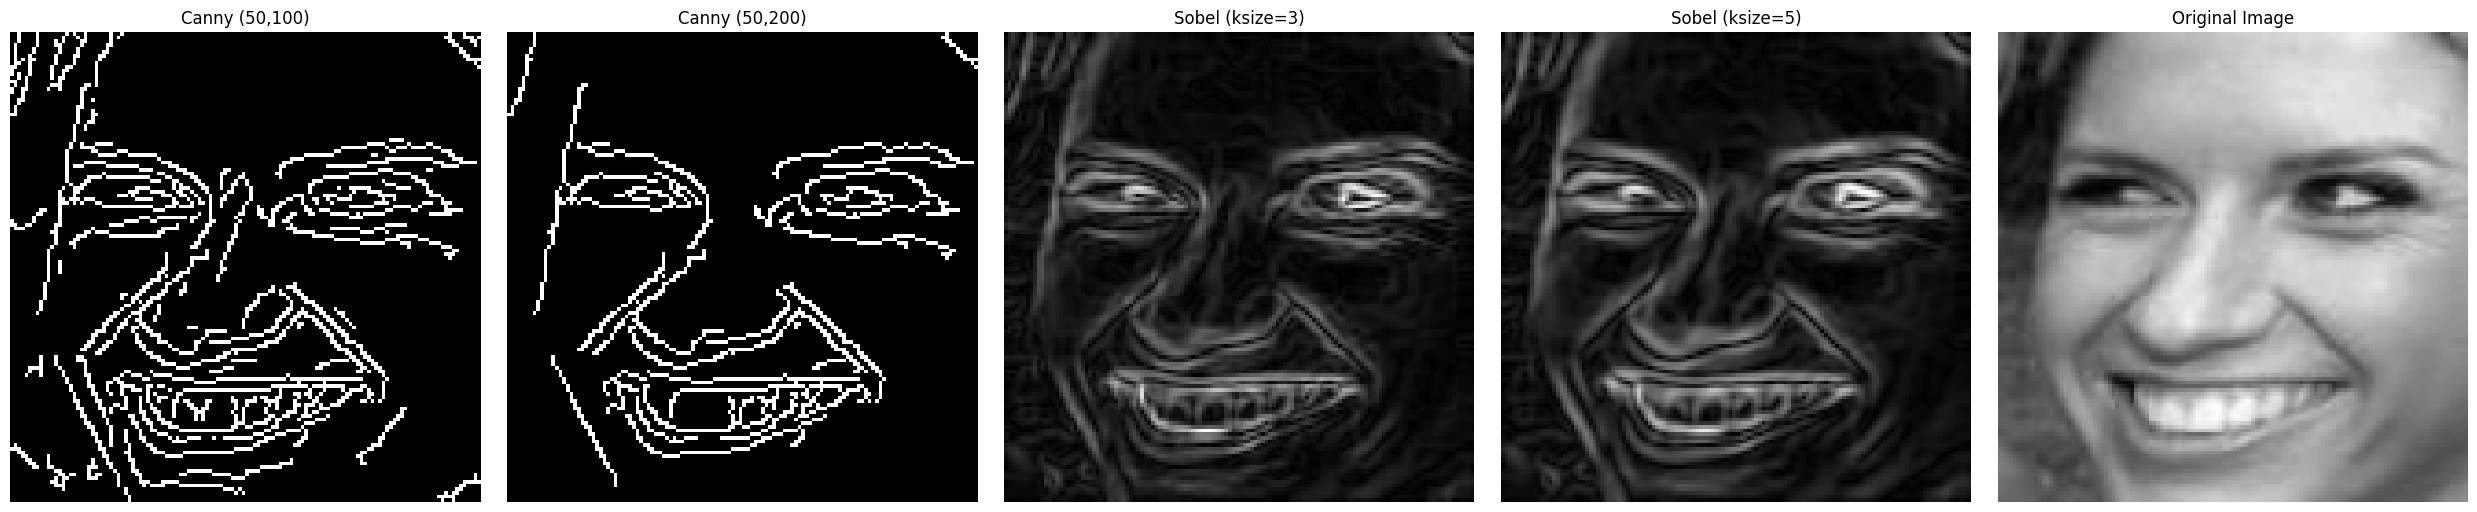

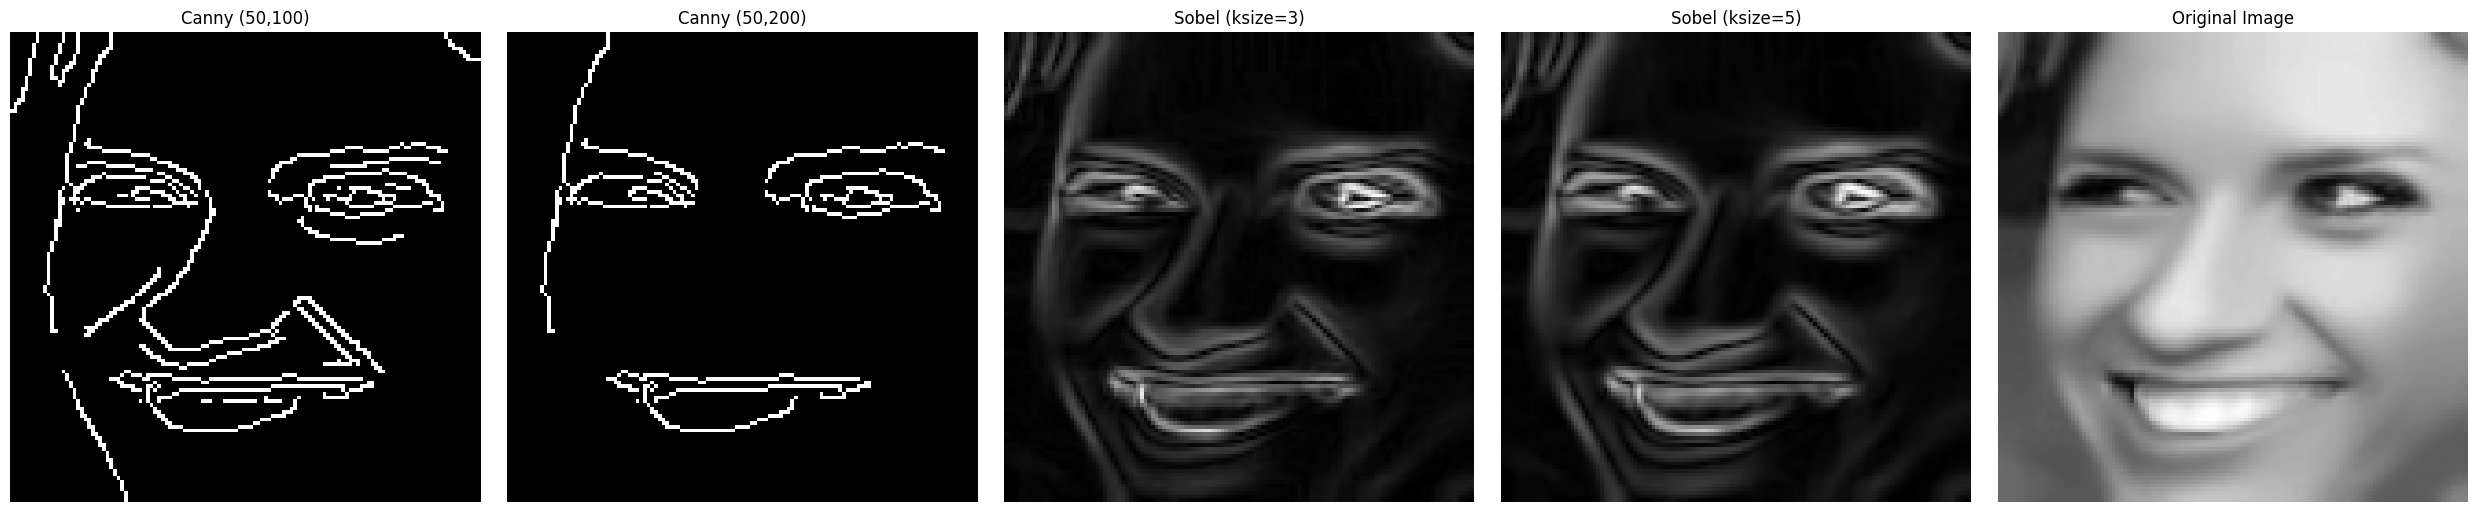

In [15]:
# Generate EDGE Detections for each setting
def apply_edge_detection(image):
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    axes = axes.flatten()

    # Loop through parameter dictionary and apply edge detection
    for i, (title, params) in enumerate(edge_detection_params.items()):
        _, edge_image = compute_edge(image, params["method"], params["params"])

        axes[i].imshow(edge_image, cmap="gray")
        axes[i].set_title(title)
        axes[i].axis("off")

    # Show the original image in the last subplot
    axes[-1].imshow(image, cmap="gray")
    axes[-1].set_title("Original Image")
    axes[-1].axis("off")

    plt.tight_layout()
    plt.show()

apply_edge_detection(image_gray_scl_rsz)
apply_edge_detection(denoised_image_gray_scl_rsz)

# 15. Experiments with Gabor

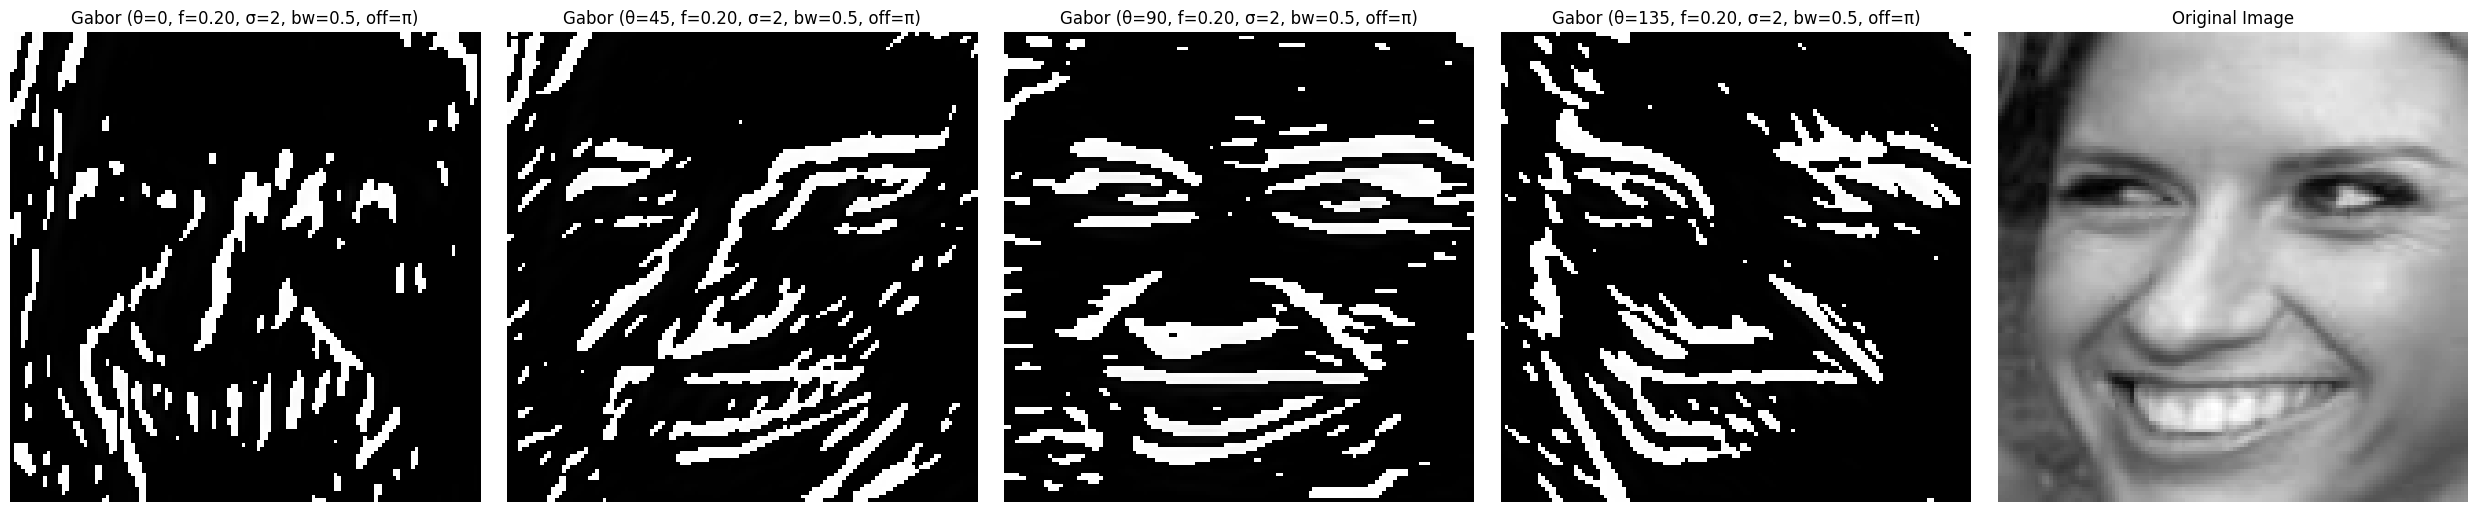

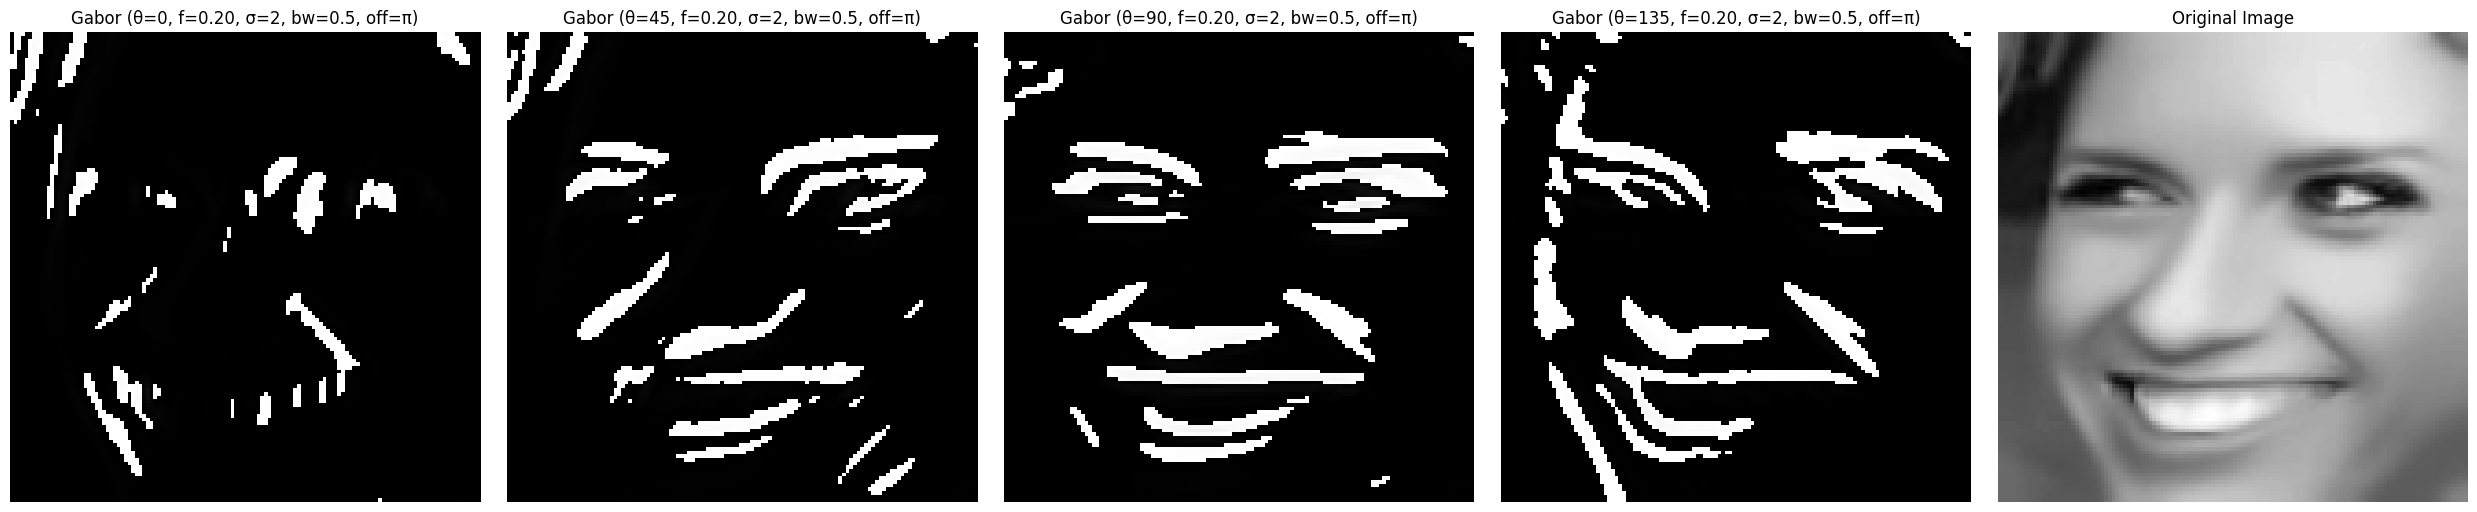

In [16]:
# Generate Gabor for each setting
def apply_gabor_filter(image):
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    axes = axes.flatten()

    # Loop through parameter dictionary and apply Gabor filters
    for i, (title, params) in enumerate(gabor_params.items()):
        _, gabor_image = compute_gabor(image, params)
        axes[i].imshow(gabor_image, cmap="gray")
        axes[i].set_title(title)
        axes[i].axis("off")

    # Show the original image in the last subplot
    axes[-1].imshow(image, cmap="gray")
    axes[-1].set_title("Original Image")
    axes[-1].axis("off")

    plt.tight_layout()
    plt.show()

apply_gabor_filter(image_gray_scl_rsz)
apply_gabor_filter(denoised_image_gray_scl_rsz)

# 16a. Complex Feature Experiment - Discrete Wavelet Transform (Haar wavelet)

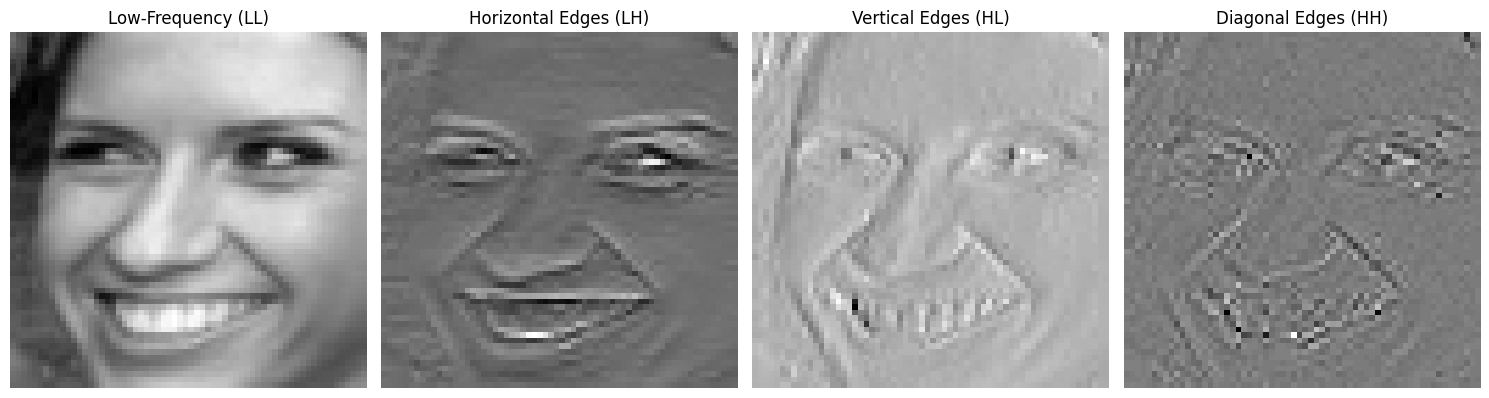

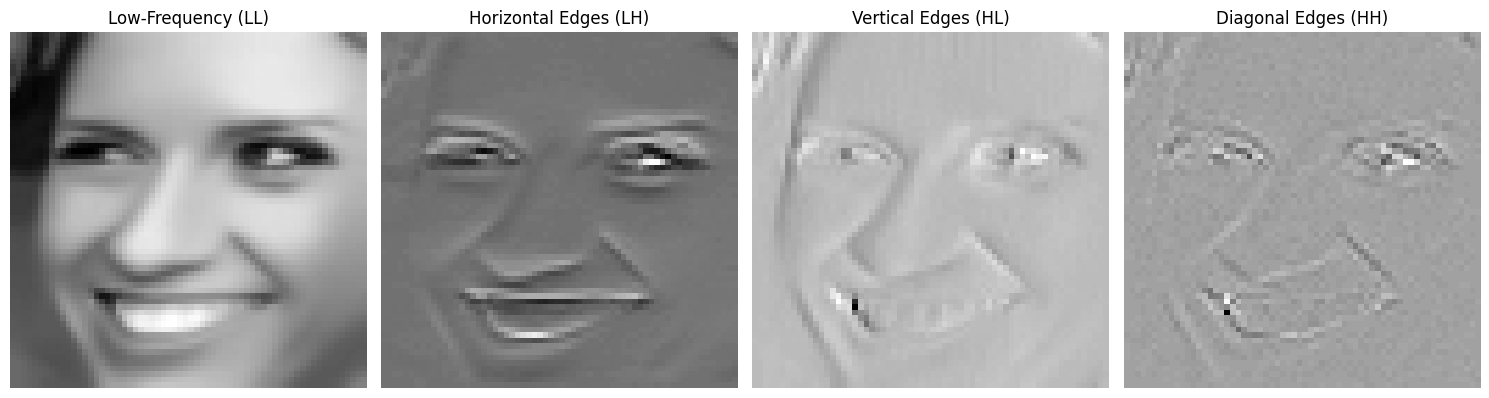

In [17]:
# Apply Discrete Wavelet Transform (Haar wavelet)
def apply_dwt_harr(image):
    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2  # Extract components

    # Plot results
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    axes[0].imshow(LL, cmap='gray')
    axes[0].set_title("Low-Frequency (LL)")
    axes[0].axis("off")

    axes[1].imshow(LH, cmap='gray')
    axes[1].set_title("Horizontal Edges (LH)")
    axes[1].axis("off")

    axes[2].imshow(HL, cmap='gray')
    axes[2].set_title("Vertical Edges (HL)")
    axes[2].axis("off")

    axes[3].imshow(HH, cmap='gray')
    axes[3].set_title("Diagonal Edges (HH)")
    axes[3].axis("off")

    plt.tight_layout()
    plt.show()

apply_dwt_harr(image_gray_scl_rsz)
apply_dwt_harr(denoised_image_gray_scl_rsz)

# 16b. Complex Feature Experiment - MediaPipe Face Mesh

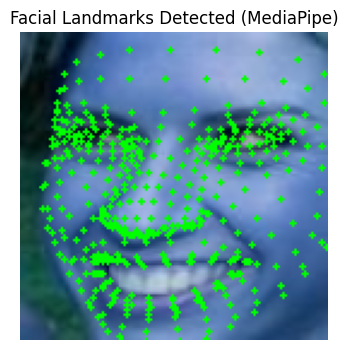

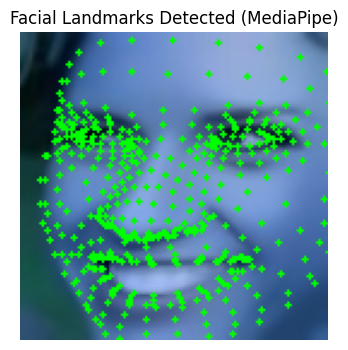

In [18]:
# Generate Face Mask
def apply_face_mesh(image):
    # Initialize MediaPipe Face Mesh
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)

    # Process image and detect facial landmarks
    results = face_mesh.process(image)
    image_lm = image.copy()

    # Draw landmarks on image
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            for landmark in face_landmarks.landmark:
                x, y = int(landmark.x * image_lm.shape[1]), int(landmark.y * image_lm.shape[0])
                cv2.circle(image_lm, (x, y), 1, (0, 255, 0), -1)

    # Display the image with detected landmarks using Matplotlib
    plt.figure(figsize=(4, 4))
    plt.imshow(image_lm)  # Use RGB image for correct color representation
    plt.axis("off")  # Hide axes for better visualization
    plt.title("Facial Landmarks Detected (MediaPipe)")
    plt.show()

apply_face_mesh(image_asis_rsz)
apply_face_mesh(denoised_image_asis_rsz)

# 16c. Complex Feature Experiment - ResNet50

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 158MB/s]


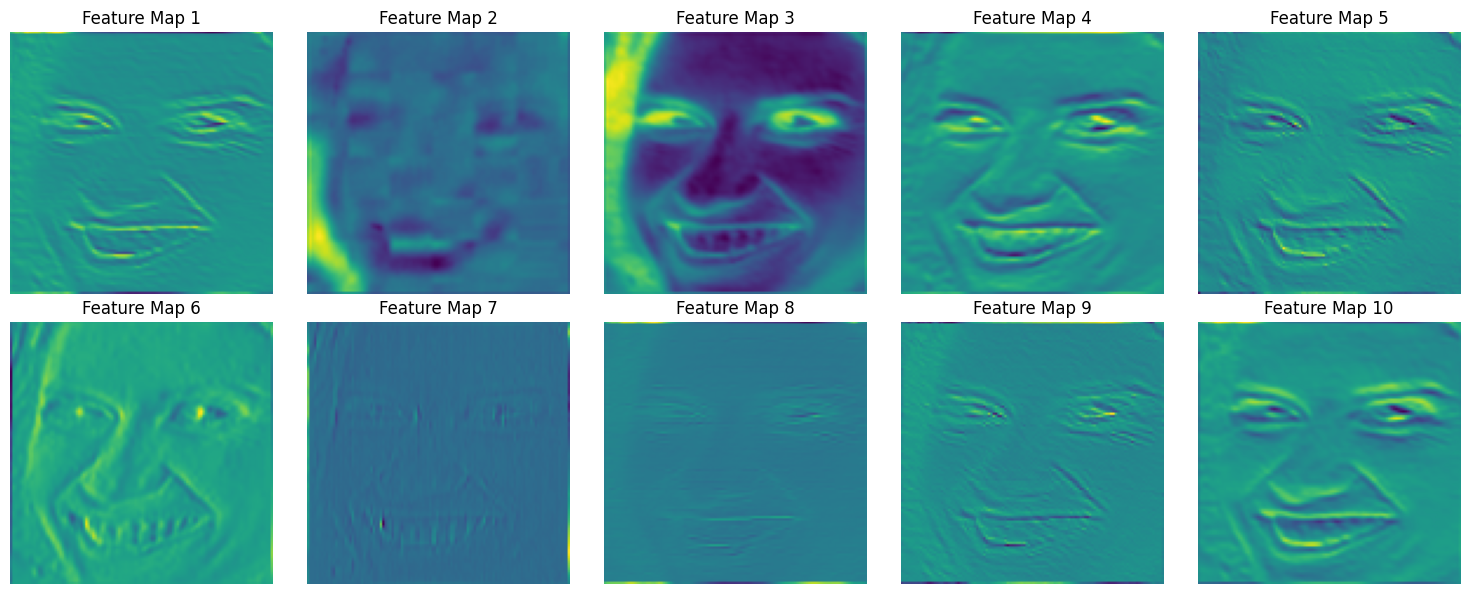

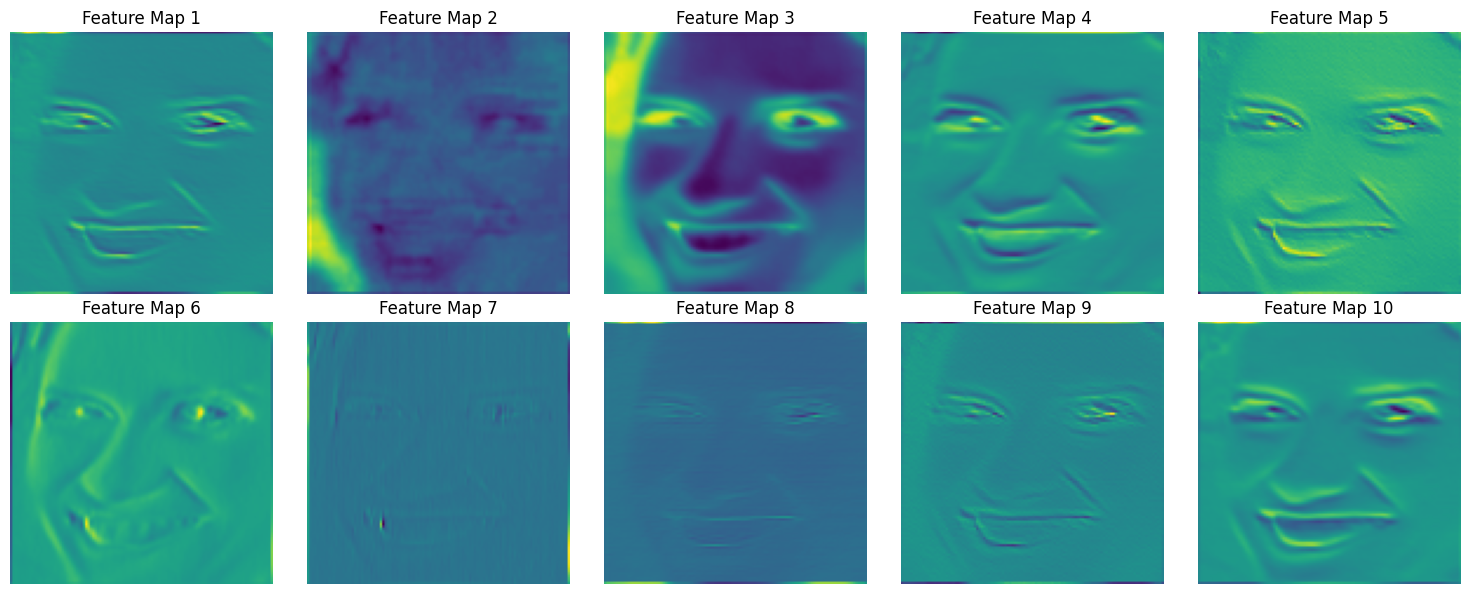

In [19]:
# Load pretrained ResNet50
resnet = models.resnet50(pretrained=True)
layer_to_visualize = resnet.conv1  # Extract an early convolutional layer
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # Remove classification layer
resnet.eval()

# Load and preprocess image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def apply_resnet50(image):
    image_pil = Image.fromarray(image) # Convert the numpy array 'image' to a PIL Image
    image_tensor = transform(image_pil).unsqueeze(0)  # Add batch dimension

    # Extract deep features
    with torch.no_grad():
        features = resnet(image_tensor)

    # print(features.shape)  # Feature vector shape

    # Extract feature maps
    with torch.no_grad():
        feature_maps = layer_to_visualize(image_tensor)

    # Convert feature maps to NumPy for visualization
    feature_maps = feature_maps.squeeze(0).detach().numpy()  # Remove batch dimension

    # Visualize first few feature maps
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Show 10 feature maps
    axes = axes.flatten()
    for i in range(10):  # Display first 10 feature maps
        axes[i].imshow(feature_maps[i], cmap='viridis')
        axes[i].axis("off")
        axes[i].set_title(f"Feature Map {i+1}")

    plt.tight_layout()
    plt.show()

apply_resnet50(image_asis_rsz)
apply_resnet50(denoised_image_asis_rsz)

# 17. Multi-Param Feature Extraction Helper

In [20]:
# HOG Feature
def compute_multi_hog(image):
    features = []
    for param in hog_params:
        # Remove 'title' from the parameters passed to hog()
        hog_param = {k: v for k, v in param.items() if k != 'title'}
        feat = hog(image, **hog_param, visualize=False, block_norm='L2-Hys')
        features.append(feat)
    return np.concatenate(features)

# Canny/Sobel Feature
def compute_multi_edge(image):
    features = []
    for param in edge_detection_params.values():
        if param["method"] == "Canny":
            edge = cv2.Canny(image, **param["params"])
        elif param["method"] == "Sobel":
            sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=param["params"]["ksize"])
            sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=param["params"]["ksize"])
            edge = np.hypot(sobelx, sobely)
        features.append(edge.flatten())
    return np.concatenate(features)

# Gabor Feature
def compute_multi_gabor(image):
    responses = []
    for param in gabor_params.values():
        response, _ = gabor(image, frequency=param["frequency"], theta=np.deg2rad(param["theta"]),
                            sigma_x=param["sigma"], sigma_y=param["sigma"],
                            bandwidth=param["bandwidth"], offset=param["offset"])
        responses.append(response.flatten())
    return np.concatenate(responses)

# Resnet Features
def compute_resnet_feature(image):
    img_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    tensor_img = transform(img_pil).unsqueeze(0)
    with torch.no_grad():
        feat = resnet(tensor_img).squeeze().numpy()
    return feat.flatten()

# MediaPipe Feature
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)

def compute_mediapipe(image):
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(img_rgb)
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            landmarks = [(lm.x, lm.y, lm.z) for lm in face_landmarks.landmark]
            return np.array(landmarks).flatten()
    return np.zeros(468 * 3)  # fallback

# 18. General Helper Functions

In [21]:
# Flush helper
def flush_to_disk(features_pkl, features, labels):
    if features:
        with open(features_pkl, "ab") as f:
            pickle.dump((features, labels), f)

# Pickle helper
def load_multiple_pickles(pkl_path):
    features, labels = [], []
    with open(pkl_path, "rb") as f:
        try:
            while True:
                x_chunk, y_chunk = pickle.load(f)
                features.extend(x_chunk)
                labels.extend(y_chunk)
        except EOFError:
            pass
    return np.array(features), np.array(labels)

# Extract and save features separately per method
def extract_and_flush_features(image_files, image_dir, method_func, feature_type="feature", is_gray=True, flush_every=1000):
    skip_train = False
    skip_test = False

    feature_type_name = feature_type.lower().replace(" ", "_").replace("-", "_").replace("+", "_").replace("/", "_")

    train_pkl = os.path.join(feature_dir, f"train_feature_{feature_type_name}.pkl")
    test_pkl = os.path.join(feature_dir, f"test_feature_{feature_type_name}.pkl")

    if os.path.exists(train_pkl):
        skip_train = True
    if os.path.exists(test_pkl):
        skip_test = True

    if skip_train and skip_test:
        return train_pkl, test_pkl

    features_train, features_test = [], []
    labels_train, labels_test = [], []

    for idx, fname in enumerate(tqdm(image_files, desc=f"Extracting Feature {feature_type}", unit="img")):
        if fname.startswith("train_"):
            if skip_train:
                continue
        elif fname.startswith("test_"):
            if skip_test:
                continue

        path = os.path.join(image_dir, fname)
        img = cv2.imread(path)
        if is_gray:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

        img = cv2.resize(img, (128, 128))
        feat = method_func(img)

        label = label_dict.get(fname.replace("_flipped", "").replace("_aligned", ""), None)
        if label is None:
            continue

        if fname.startswith("train_"):
            features_train.append(feat)
            labels_train.append(label)
        elif fname.startswith("test_"):
            features_test.append(feat)
            labels_test.append(label)

        if len(features_train) >= flush_every:
            flush_to_disk(train_pkl, features_train, labels_train)
            features_train, labels_train = [], []
        if len(features_test) >= flush_every:
            flush_to_disk(test_pkl, features_test, labels_test)
            features_test, labels_test = [], []

    # Final flush
    flush_to_disk(train_pkl, features_train, labels_train)
    flush_to_disk(test_pkl, features_test, labels_test)

    return train_pkl, test_pkl

# Read and apply PCA on each feature type
def reduce_feature_pkl(input_pkl, output_pkl, n_components=100):
    scaler = StandardScaler()
    pca = IncrementalPCA(n_components=n_components, batch_size=1000)

    print("Fitting StandardScaler and IncrementalPCA on chunks...")

    # First pass: Count total chunks
    chunk_offsets = []
    with open(input_pkl, "rb") as f:
        while True:
            try:
                offset = f.tell()
                pickle.load(f)
                chunk_offsets.append(offset)
            except EOFError:
                break

    # Pass 1: Fit scaler
    print("Pass 1/3: Fitting StandardScaler")
    with open(input_pkl, "rb") as f:
        for _ in tqdm(chunk_offsets, desc="Fitting Scaler", unit="chunk"):
            x_chunk, _ = pickle.load(f)
            scaler.partial_fit(x_chunk)

    # Pass 2: Fit IncrementalPCA
    print("Pass 2/3: Fitting IncrementalPCA")
    with open(input_pkl, "rb") as f:
        for _ in tqdm(chunk_offsets, desc="Fitting PCA", unit="chunk"):
            x_chunk, _ = pickle.load(f)
            x_scaled = scaler.transform(x_chunk)
            pca.partial_fit(x_scaled)

    # Pass 3: Transform and save reduced features
    print("Pass 3/3: Transforming and saving reduced features")
    with open(input_pkl, "rb") as fin, open(output_pkl, "wb") as fout:
        for _ in tqdm(chunk_offsets, desc="Saving Reduced Features", unit="chunk"):
            x_chunk, y_chunk = pickle.load(fin)
            x_scaled = scaler.transform(x_chunk)
            x_reduced = pca.transform(x_scaled)
            pickle.dump((x_reduced, y_chunk), fout)

    return scaler, pca

# Combine all feature pkl files into one and apply scaling
def combine_and_scale_feature_pkls(pkl_files, output_pkl):
    all_features, all_labels = [], []
    for pkl in pkl_files:
        with open(pkl, "rb") as f:
            while True:
                try:
                    x_chunk, y_chunk = pickle.load(f)
                    all_features.extend(x_chunk)
                    all_labels.extend(y_chunk)
                except EOFError:
                    break
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(all_features)
    with open(output_pkl, "wb") as f:
        pickle.dump((x_scaled, all_labels), f)
    return scaler

# 19. Extract Features

In [22]:
# Extract features separately
## HOG + Edge on denoised
def hog_edge_method(img):
    return np.concatenate([
        compute_multi_hog(img),
        compute_multi_edge(img)
    ])

## Gabor + ResNet on original
def gabor_resnet_method(img):
    return np.concatenate([
        compute_multi_gabor(img),
        compute_resnet_feature(img)
    ])

train_hog_pkl, test_hog_pkl = extract_and_flush_features(image_files, denoised_image_dir, compute_multi_hog, "HOG")
train_edge_pkl, test_edge_pkl = extract_and_flush_features(image_files, image_dir, compute_multi_edge, "EDGE")
train_gabor_pkl, test_gabor_pkl = extract_and_flush_features(image_files, image_dir, compute_multi_gabor, "Gabor")
train_resnet_pkl, test_resnet_pkl = extract_and_flush_features(image_files, image_dir, compute_resnet_feature, "ResNet", False)
# train_hog_edge_pkl, test_hog_edge_pkl = extract_and_flush_features(image_files, denoised_image_dir, hog_edge_method, "HOG+EDGE")
# train_gabor_resnet_pkl, test_gabor_resnet_pkl = extract_and_flush_features(image_files, image_dir, gabor_resnet_method, "Gabor+ResNet")

# 20. Apply PCA

In [23]:
# Apply PCA per feature set
train_hog_reduced_pkl = os.path.join(feature_dir, "train_feature_hog_reduced.pkl")
test_hog_reduced_pkl = os.path.join(feature_dir, "test_feature_hog_reduced.pkl")
train_edge_reduced_pkl = os.path.join(feature_dir, "train_feature_edge_reduced.pkl")
test_edge_reduced_pkl = os.path.join(feature_dir, "test_feature_edge_reduced.pkl")
train_gabor_reduced_pkl = os.path.join(feature_dir, "train_feature_gabor_reduced.pkl")
test_gabor_reduced_pkl = os.path.join(feature_dir, "test_feature_gabor_reduced.pkl")
train_resnet_reduced_pkl = os.path.join(feature_dir, "train_feature_resnet_reduced.pkl")
test_resnet_reduced_pkl = os.path.join(feature_dir, "test_feature_resnet_reduced.pkl")

# train_hog_edge_reduced_pkl = os.path.join(feature_dir, "train_feature_hog_edge_reduced.pkl")
# test_hog_edge_reduced_pkl = os.path.join(feature_dir, "test_feature_hog_edge_reduced.pkl")
# train_gabor_resnet_reduced_pkl = os.path.join(feature_dir, "train_feature_gabor_resnet_reduced.pkl")
# test_gabor_resnet_reduced_pkl = os.path.join(feature_dir, "test_feature_gabor_resnet_reduced.pkl")

print("\nApplying PCA...")
if not os.path.exists(train_hog_reduced_pkl):
    reduce_feature_pkl(train_hog_pkl, train_hog_reduced_pkl, n_components=100)

if not os.path.exists(test_hog_reduced_pkl):
    reduce_feature_pkl(test_hog_pkl, test_hog_reduced_pkl, n_components=100)

if not os.path.exists(train_edge_reduced_pkl):
    reduce_feature_pkl(train_edge_pkl, train_edge_reduced_pkl, n_components=100)

if not os.path.exists(test_edge_reduced_pkl):
    reduce_feature_pkl(test_edge_pkl, test_edge_reduced_pkl, n_components=100)

if not os.path.exists(train_gabor_reduced_pkl):
    reduce_feature_pkl(train_gabor_pkl, train_gabor_reduced_pkl, n_components=100)

if not os.path.exists(test_gabor_reduced_pkl):
    reduce_feature_pkl(test_gabor_pkl, test_gabor_reduced_pkl, n_components=100)

if not os.path.exists(train_resnet_reduced_pkl):
    reduce_feature_pkl(train_resnet_pkl, train_resnet_reduced_pkl, n_components=100)

if not os.path.exists(test_resnet_reduced_pkl):
    reduce_feature_pkl(test_resnet_pkl, test_resnet_reduced_pkl, n_components=100)

# reduce_feature_pkl(train_hog_edge_pkl, train_hog_edge_reduced_pkl, n_components=100)
# reduce_feature_pkl(test_hog_edge_pkl, test_hog_edge_reduced_pkl, n_components=100)
# reduce_feature_pkl(train_gabor_resnet_pkl, train_gabor_resnet_reduced_pkl, n_components=100)
# reduce_feature_pkl(test_gabor_resnet_pkl, test_gabor_resnet_reduced_pkl, n_components=100)

# Combine and scale final features
print("\nCombining and scaling features...")
if not os.path.exists(os.path.join(feature_dir, "final_train_features_scaled.pkl")):
    combine_and_scale_feature_pkls(
        # [train_hog_edge_reduced_pkl, train_gabor_resnet_reduced_pkl],
        [train_hog_reduced_pkl, train_edge_reduced_pkl, train_gabor_reduced_pkl, train_resnet_reduced_pkl],
        os.path.join(feature_dir, "final_train_features_scaled.pkl")
    )

if not os.path.exists(os.path.join(feature_dir, "final_test_features_scaled.pkl")):
    combine_and_scale_feature_pkls(
        # [test_hog_edge_reduced_pkl, test_gabor_resnet_reduced_pkl],
        [test_hog_reduced_pkl, test_edge_reduced_pkl, test_gabor_reduced_pkl, test_resnet_reduced_pkl],
        os.path.join(feature_dir, "final_test_features_scaled.pkl")
    )

print("\nApplying PCA again...")
if not os.path.exists(os.path.join(feature_dir, "final_train_features_scaled_and_reduced.pkl")):
    reduce_feature_pkl(os.path.join(feature_dir, "final_train_features_scaled.pkl"),
                       os.path.join(feature_dir, "final_train_features_scaled_and_reduced.pkl"),
                       n_components=100)

if not os.path.exists(os.path.join(feature_dir, "final_test_features_scaled_and_reduced.pkl")):
    reduce_feature_pkl(os.path.join(feature_dir, "final_test_features_scaled.pkl"),
                       os.path.join(feature_dir, "final_test_features_scaled_and_reduced.pkl"),
                       n_components=100)

print("Feature extraction and scaling complete!")


Applying PCA...

Combining and scaling features...

Applying PCA again...
Feature extraction and scaling complete!


# 21. Split Data for Train, Validate and Test

In [24]:
# features_train_pkl = os.path.join(feature_dir, "final_train_features_scaled.pkl")
# features_test_pkl = os.path.join(feature_dir, "final_test_features_scaled.pkl")
features_train_pkl = os.path.join(feature_dir, "final_train_features_scaled_and_reduced.pkl")
features_test_pkl = os.path.join(feature_dir, "final_test_features_scaled_and_reduced.pkl")

def load_multiple_pickles(pkl_path):
    features, labels = [], []
    with open(pkl_path, "rb") as f:
        try:
            while True:
                x_chunk, y_chunk = pickle.load(f)
                features.extend(x_chunk)
                labels.extend(y_chunk)
        except EOFError:
            pass
    return np.array(features), np.array(labels)

# Load feature datasets
x_train, y_train = load_multiple_pickles(features_train_pkl)
x_test, y_test = load_multiple_pickles(features_test_pkl)

# Split training into train/val
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"X_train shape: {x_train.shape}")
print(f"Y_train shape: {y_train.shape}")
print(f"X_train_split shape: {x_train_split.shape}")
print(f"Y_train_split shape: {y_train_split.shape}")
print(f"X_val_split shape: {x_val_split.shape}")
print(f"Y_val_split shape: {y_val_split.shape}")

print("Splitting complete!")

# Count class frequencies in y_train
class_counts = Counter(y_train_split)
total_samples = len(y_train_split)

# Inverse frequency (you can also use 1 / sqrt(count) for less aggressive adjustment)
class_weight = {cls: total_samples / (len(class_counts) * count) for cls, count in class_counts.items()}

print("Computed class weights:", class_weight)

X_train shape: (68984, 100)
Y_train shape: (68984,)
X_train_split shape: (55187, 100)
Y_train_split shape: (55187,)
X_val_split shape: (13797, 100)
Y_val_split shape: (13797,)
Splitting complete!
Computed class weights: {np.str_('7'): 0.9760873025699075, np.str_('5'): 0.6215102201700546, np.str_('4'): 0.5162971278884835, np.str_('1'): 0.9549245570321152, np.str_('6'): 1.7473087639311045, np.str_('3'): 1.717990225072378, np.str_('2'): 4.38479262672811}


# 21a. Train using Logistic Regression

In [25]:
# Logistic Regression with GridSearchCV
print("\nTraining Logistic Regression with GridSearchCV...")
lr_param_grid = {'C': [0.01, 0.1, 1, 10]}
lr = GridSearchCV(LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced'), lr_param_grid, cv=3, scoring='accuracy', verbose=2)
lr.fit(x_train_split, y_train_split)

# Save Logistic Regression model
joblib.dump(lr.best_estimator_, os.path.join(model_dir, "logistic_model.pkl"))

# Evaluate on validation and test sets
y_val_pred_lr = lr.predict(x_val_split)
y_test_pred_lr = lr.predict(x_test)

print("\nLogistic Regression Report (Validation):")
print(classification_report(y_val_split, y_val_pred_lr))

print("\nLogistic Regression Report (Test):")
print(classification_report(y_test, y_test_pred_lr))


Training Logistic Regression with GridSearchCV...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END .............................................C=0.01; total time=   2.3s
[CV] END .............................................C=0.01; total time=   2.4s
[CV] END .............................................C=0.01; total time=   2.2s
[CV] END ..............................................C=0.1; total time=   2.4s
[CV] END ..............................................C=0.1; total time=   2.2s
[CV] END ..............................................C=0.1; total time=   2.2s
[CV] END ................................................C=1; total time=   2.3s
[CV] END ................................................C=1; total time=   2.4s
[CV] END ................................................C=1; total time=   2.3s
[CV] END ...............................................C=10; total time=   2.3s
[CV] END ...............................................C=10; total time=   2.2

# 21b. Train using SVM

In [ ]:
# SVM with GridSearchCV
print("\nTraining SVM with GridSearchCV...")
svm_param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svm = GridSearchCV(SVC(probability=True), svm_param_grid, cv=3, scoring='accuracy', verbose=2)
svm.fit(x_train_split, y_train_split)

# Save SVM model
joblib.dump(svm.best_estimator_, os.path.join(model_dir, "svm_model.pkl"))

# Evaluate
y_val_pred_svm = svm.predict(x_val_split)
y_test_pred_svm = svm.predict(x_test)

print("\nSVM Report (Validation):")
print(classification_report(y_val_split, y_val_pred_svm))

print("\nSVM Report (Test):")
print(classification_report(y_test, y_test_pred_svm))

# Log Loss Evaluation (optional)
y_val_probs = svm.predict_proba(x_val_split)
print("\nValidation Log Loss (SVM):", log_loss(y_val_split, y_val_probs))

# Confusion Matrix for Test Predictions
cm = confusion_matrix(y_test, y_test_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (SVM - Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

print("\nModel training and evaluation complete!")


Training SVM with GridSearchCV...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ...............................C=0.1, kernel=linear; total time=20.6min
[CV] END ...............................C=0.1, kernel=linear; total time=19.8min
[CV] END ...............................C=0.1, kernel=linear; total time=19.4min
[CV] END ..................................C=0.1, kernel=rbf; total time=18.9min
[CV] END ..................................C=0.1, kernel=rbf; total time=19.0min
[CV] END ..................................C=0.1, kernel=rbf; total time=19.0min
[CV] END .................................C=1, kernel=linear; total time=66.2min
[CV] END .................................C=1, kernel=linear; total time=67.1min
[CV] END .................................C=1, kernel=linear; total time=65.7min
[CV] END ....................................C=1, kernel=rbf; total time=20.8min
[CV] END ....................................C=1, kernel=rbf; total time=21.0min
[CV] END .....

# ?? Ignore - Old Code

In [ ]:
# emotion model training

features_train_pkl = os.path.join(feature_dir, "final_train_features_scaled.pkl")
features_test_pkl = os.path.join(feature_dir, "final_test_features_scaled.pkl")

def load_multiple_pickles(pkl_path):
    features, labels = [], []
    with open(pkl_path, "rb") as f:
        try:
            while True:
                x_chunk, y_chunk = pickle.load(f)
                features.extend(x_chunk)
                labels.extend(y_chunk)
        except EOFError:
            pass
    return np.array(features), np.array(labels)

# Load feature datasets
x_train, y_train = load_multiple_pickles(features_train_pkl)
x_test, y_test = load_multiple_pickles(features_test_pkl)

# Split training into train/val
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(len(x_train_split))
print(len(x_val_split))
print(len(x_test))

# Logistic Regression with GridSearchCV
lr_param_grid = {'C': [0.01, 0.1, 1, 10]}
lr = GridSearchCV(LogisticRegression(max_iter=1000, solver='liblinear'), lr_param_grid, cv=3, scoring='accuracy')
lr.fit(x_train_split, y_train_split)

# Save Logistic Regression model
joblib.dump(lr.best_estimator_, os.path.join(model_dir, "logistic_model.pkl"))

# Evaluate on validation and test sets
y_val_pred_lr = lr.predict(x_val_split)
y_test_pred_lr = lr.predict(x_test)

print("\nLogistic Regression Report (Validation):")
print(classification_report(y_val_split, y_val_pred_lr))

print("\nLogistic Regression Report (Test):")
print(classification_report(y_test, y_test_pred_lr))

# SVM with GridSearchCV
svm_param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svm = GridSearchCV(SVC(probability=True), svm_param_grid, cv=3, scoring='accuracy')
svm.fit(x_train_split, y_train_split)

# Save SVM model
joblib.dump(svm.best_estimator_, os.path.join(model_dir, "svm_model.pkl"))

# Evaluate
y_val_pred_svm = svm.predict(x_val_split)
y_test_pred_svm = svm.predict(x_test)

print("\nSVM Report (Validation):")
print(classification_report(y_val_split, y_val_pred_svm))

print("\nSVM Report (Test):")
print(classification_report(y_test, y_test_pred_svm))

# Log Loss Evaluation (optional)
y_val_probs = svm.predict_proba(x_val_split)
print("\nValidation Log Loss (SVM):", log_loss(y_val_split, y_val_probs))

# Confusion Matrix for Test Predictions
cm = confusion_matrix(y_test, y_test_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (SVM - Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

print("\nModel training and evaluation complete!")

55187
13797
17084

Logistic Regression Report (Validation):
              precision    recall  f1-score   support

           1       0.44      0.25      0.32      2064
           2       0.41      0.02      0.04       450
           3       0.36      0.01      0.03      1147
           4       0.37      0.74      0.49      3818
           5       0.35      0.42      0.38      3171
           6       0.49      0.13      0.21      1128
           7       0.38      0.14      0.20      2019

    accuracy                           0.37     13797
   macro avg       0.40      0.25      0.24     13797
weighted avg       0.39      0.37      0.32     13797


Logistic Regression Report (Test):
              precision    recall  f1-score   support

           1       0.26      0.15      0.19      2632
           2       0.18      0.01      0.01       592
           3       0.10      0.01      0.01      1280
           4       0.34      0.68      0.45      4740
           5       0.26      0.32   